## Compare Random Forest in the case of binary class (Sell, Buy)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_random_forest,
)

In [2]:
metric = "accuracy"

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline CatBoost Classifier without new data + r

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [9]:
orig_df["r"] = interest_rate

### In sample predictions

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df, target.values.flatten(), test_size=199, random_state=1968, shuffle=True
)

### Hyper-parameters tuning using Optuna

In [11]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_random_forest(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=600,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-13 01:00:38,316] A new study created in memory with name: no-name-0f142b64-b893-4cf0-8fbc-cd6ea7c5ab63
[I 2024-02-13 01:00:40,070] Trial 0 finished with value: 0.7102750249282677 and parameters: {'max_features': 'log2', 'max_depth': 17, 'n_estimators': 88, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7102750249282677.
[I 2024-02-13 01:00:42,734] Trial 1 finished with value: 0.715097881605991 and parameters: {'max_features': 'sqrt', 'max_depth': 12, 'n_estimators': 172, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.715097881605991.
[I 2024-02-13 01:00:45,267] Trial 2 finished with value: 0.7238685618933273 and parameters: {'max_features': None, 'max_depth': 10, 'n_estimators': 126, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 2 with value: 0.7238685618933273.
[I 2024-0

Number of finished trials: 150
Best trial:
  Value: 0.7398302842839991
  Params: 
    max_features: log2
    max_depth: 18
    n_estimators: 81
    min_samples_split: 7
    min_samples_leaf: 2
    bootstrap: False
    criterion: log_loss


In [12]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**study.best_params, random_state=1968)),
    ]
)

In [13]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='log_loss',
                                        max_depth=18, max_features='log2',
                                        min_samples_leaf=2, min_samples_split=7,
                                        n_estimators=81, random_state=1968))])

In [14]:
predictions = pipe.predict(X_test)

In [15]:
pipe.score(X_test, y_test)

0.7839195979899497

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       100
           1       0.80      0.76      0.78        99

    accuracy                           0.78       199
   macro avg       0.78      0.78      0.78       199
weighted avg       0.78      0.78      0.78       199



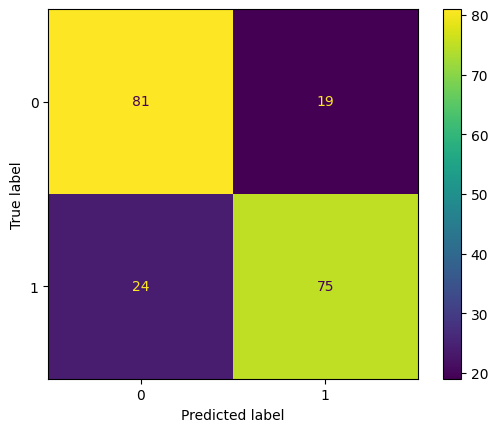

In [16]:
display_report(y_test, predictions)

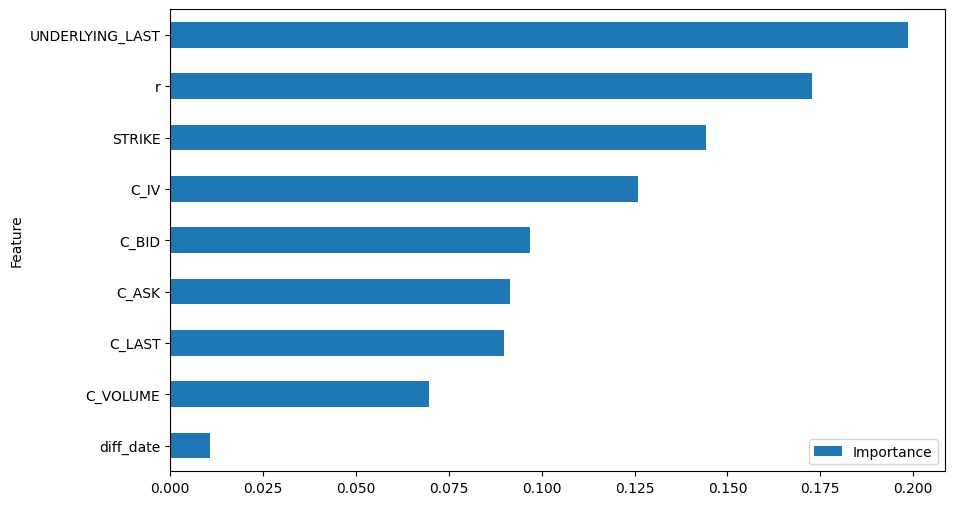

In [17]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [18]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [19]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [20]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-01-17,0,280.0,2.40,2018-02-07,267.670013,0.000000,-2.400000,0.000000,-2.400000
2018-02-09,1,262.0,5.77,2018-03-02,269.079987,1.309987,1.309987,1.309987,-1.090013
2018-02-22,0,270.0,4.26,2018-03-14,275.299988,0.000000,1.039988,1.309987,-0.050026
2018-02-28,0,271.0,4.86,2018-03-21,270.429993,0.000000,-4.860000,1.309987,-4.910026
2018-03-08,0,274.0,2.85,2018-03-29,263.149994,0.000000,-2.850000,1.309987,-7.760026
...,...,...,...,...,...,...,...,...,...
2023-11-22,0,455.0,5.55,2023-12-15,469.329987,0.000000,8.779987,408.450160,286.530096
2023-11-27,1,455.0,4.55,2023-12-15,469.329987,9.779987,9.779987,418.230146,296.310083
2023-11-30,0,456.0,5.38,2023-12-22,473.649994,0.000000,12.269994,418.230146,308.580077


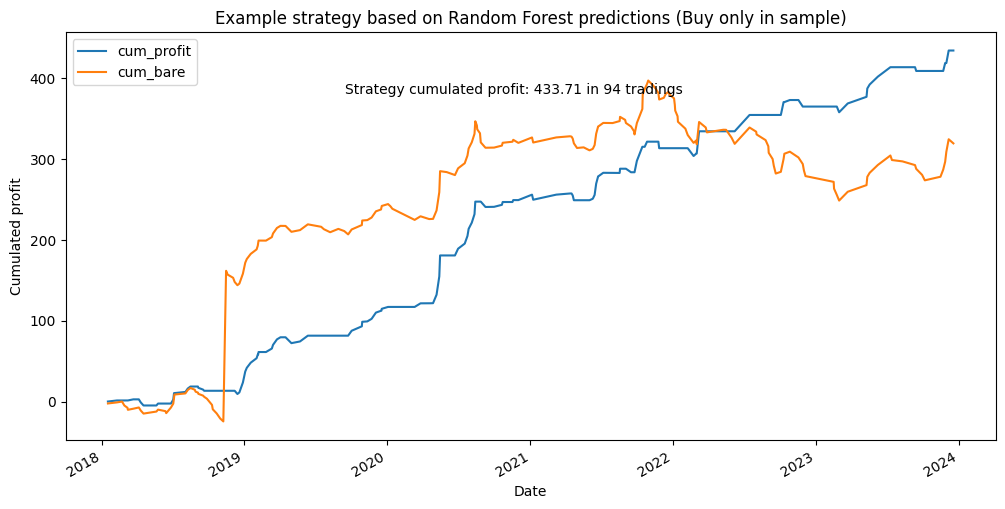

In [21]:
plot_strategy(strategy_df, "Random Forest", "(Buy only in sample)")

### Out-of-sample predictions

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=199,
    random_state=1968,
    shuffle=False,
)

In [23]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**study.best_params, random_state=1968)),
    ]
)

In [24]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='log_loss',
                                        max_depth=18, max_features='log2',
                                        min_samples_leaf=2, min_samples_split=7,
                                        n_estimators=81, random_state=1968))])

In [25]:
predictions = pipe.predict(X_test)

In [26]:
pipe.score(X_test, y_test)

0.5326633165829145

              precision    recall  f1-score   support

           0       0.51      1.00      0.68        98
           1       1.00      0.08      0.15       101

    accuracy                           0.53       199
   macro avg       0.76      0.54      0.41       199
weighted avg       0.76      0.53      0.41       199



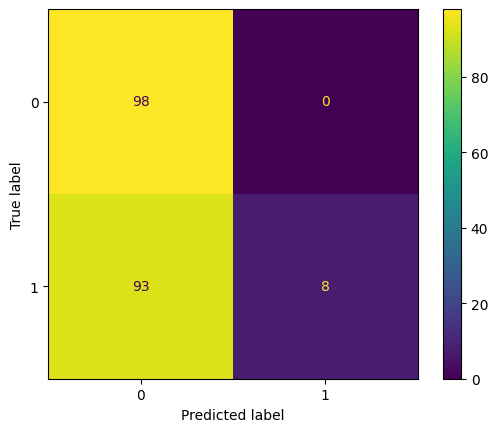

In [27]:
display_report(y_test, predictions)

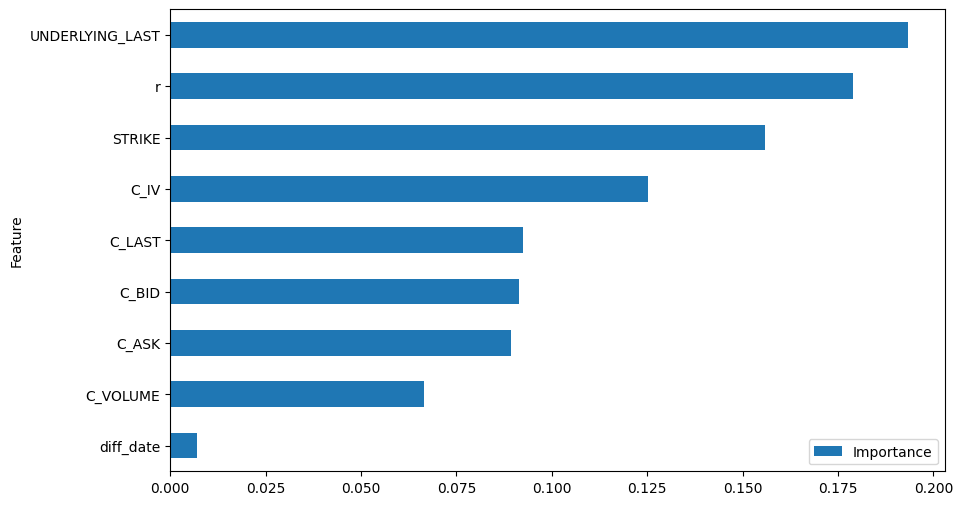

In [28]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [29]:
compare_df["bare_rf_pred_out"] = predictions

### Backtesting

In [30]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [31]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,1,388.0,7.72,2023-01-27,405.679993,9.959993,9.959993,42.359978,42.359978
2023-01-09,1,388.0,7.46,2023-01-27,405.679993,10.219993,10.219993,52.579971,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,52.579971,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,106.600011,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,106.600011,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,106.600011,401.389886


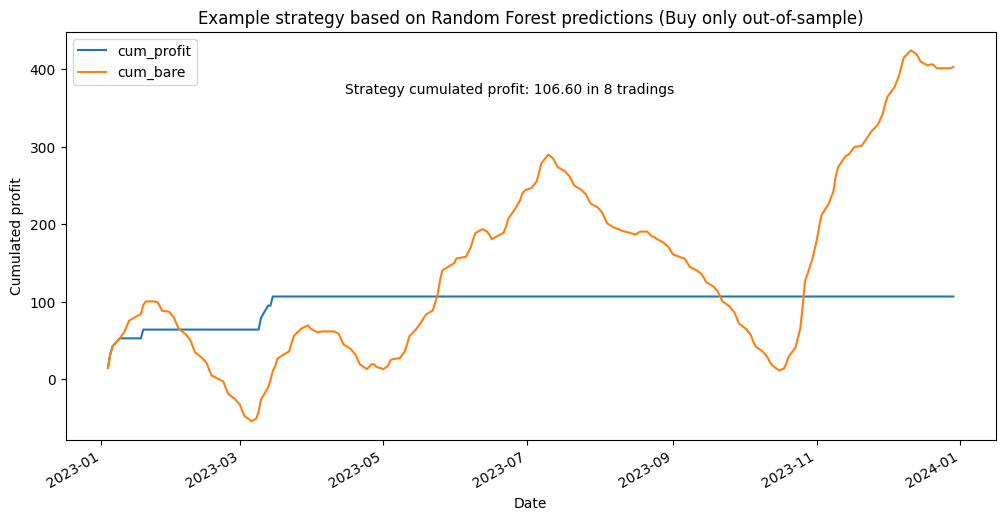

In [32]:
plot_strategy(strategy_df, "Random Forest", "(Buy only out-of-sample)")

## Random Forest with data from MC simulation and additional features

In [33]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [34]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### In-sample predictions

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df, target.values.flatten(), test_size=199, random_state=1968, shuffle=True
)

### Hyper-parameters tuning using Optuna

In [36]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_random_forest(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=1200,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-13 01:05:28,733] A new study created in memory with name: no-name-b63cbc86-1431-4ccb-9eee-67b56d8516ad
[I 2024-02-13 01:05:29,716] Trial 0 finished with value: 0.614509777985796 and parameters: {'max_features': 'log2', 'max_depth': 3, 'n_estimators': 78, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.614509777985796.
[I 2024-02-13 01:05:42,366] Trial 1 finished with value: 0.5865773997273153 and parameters: {'max_features': None, 'max_depth': 5, 'n_estimators': 196, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.614509777985796.
[I 2024-02-13 01:05:46,576] Trial 2 finished with value: 0.7462047984371503 and parameters: {'max_features': 'sqrt', 'max_depth': 16, 'n_estimators': 139, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7462047984371503.
[I 2024-

Number of finished trials: 150
Best trial:
  Value: 0.7613652550823141
  Params: 
    max_features: sqrt
    max_depth: 18
    n_estimators: 134
    min_samples_split: 5
    min_samples_leaf: 3
    bootstrap: False
    criterion: gini


In [37]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**study.best_params, random_state=1968)),
    ]
)

In [38]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=18,
                                        min_samples_leaf=3, min_samples_split=5,
                                        n_estimators=134, random_state=1968))])

In [39]:
predictions = pipe.predict(X_test)

In [40]:
pipe.score(X_test, y_test)

0.8040201005025126

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       100
           1       0.83      0.76      0.79        99

    accuracy                           0.80       199
   macro avg       0.81      0.80      0.80       199
weighted avg       0.81      0.80      0.80       199



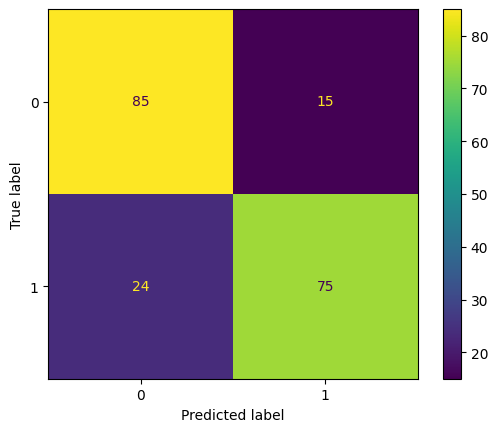

In [41]:
display_report(y_test, predictions)

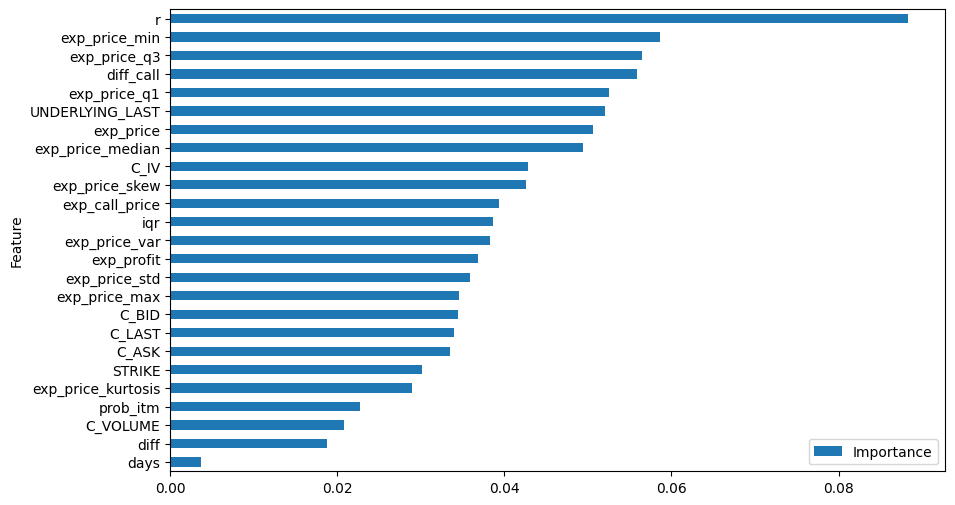

In [42]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [43]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [44]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [45]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-01-17,0,280.0,2.40,2018-02-07,267.670013,0.000000,-2.400000,0.000000,-2.400000
2018-02-09,1,262.0,5.77,2018-03-02,269.079987,1.309987,1.309987,1.309987,-1.090013
2018-02-22,0,270.0,4.26,2018-03-14,275.299988,0.000000,1.039988,1.309987,-0.050026
2018-02-28,1,271.0,4.86,2018-03-21,270.429993,-4.860000,-4.860000,-3.550013,-4.910026
2018-03-08,0,274.0,2.85,2018-03-29,263.149994,0.000000,-2.850000,-3.550013,-7.760026
...,...,...,...,...,...,...,...,...,...
2023-11-22,0,455.0,5.55,2023-12-15,469.329987,0.000000,8.779987,406.900175,286.530096
2023-11-27,1,455.0,4.55,2023-12-15,469.329987,9.779987,9.779987,416.680161,296.310083
2023-11-30,0,456.0,5.38,2023-12-22,473.649994,0.000000,12.269994,416.680161,308.580077


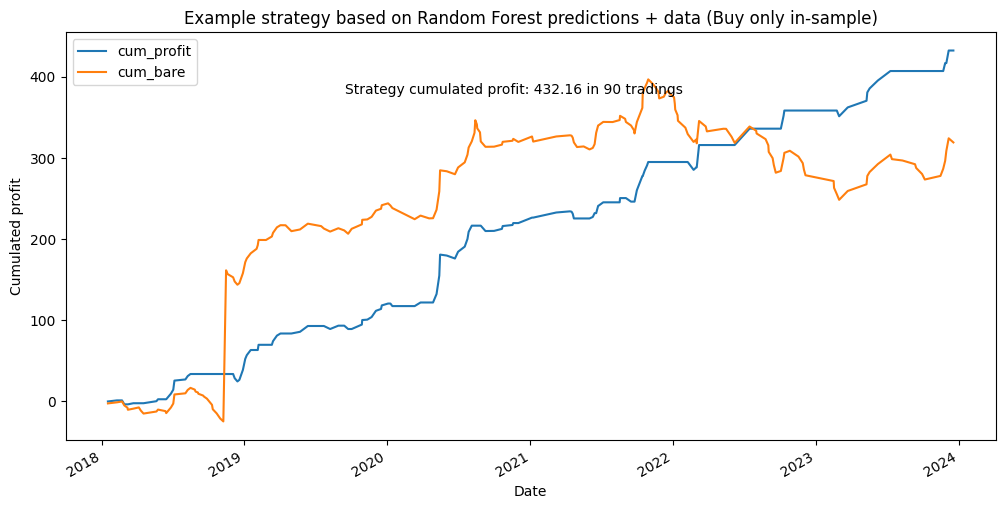

In [46]:
plot_strategy(strategy_df, "Random Forest", "+ data (Buy only in-sample)")

### Out-of-sample predictions

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=199,
    random_state=1968,
    shuffle=False,
)

In [48]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**study.best_params, random_state=1968)),
    ]
)

In [49]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=18,
                                        min_samples_leaf=3, min_samples_split=5,
                                        n_estimators=134, random_state=1968))])

In [50]:
predictions = pipe.predict(X_test)

In [51]:
pipe.score(X_test, y_test)

0.5628140703517588

              precision    recall  f1-score   support

           0       0.54      0.83      0.65        98
           1       0.65      0.31      0.42       101

    accuracy                           0.56       199
   macro avg       0.59      0.57      0.53       199
weighted avg       0.59      0.56      0.53       199



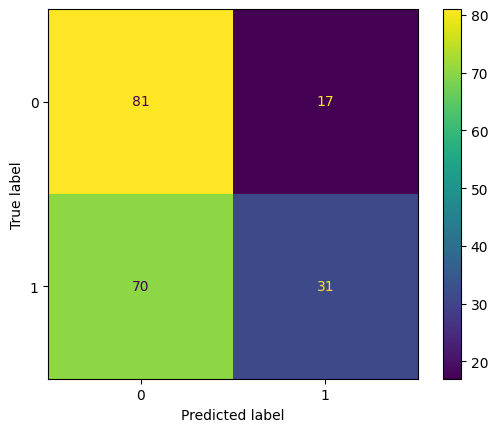

In [52]:
display_report(y_test, predictions)

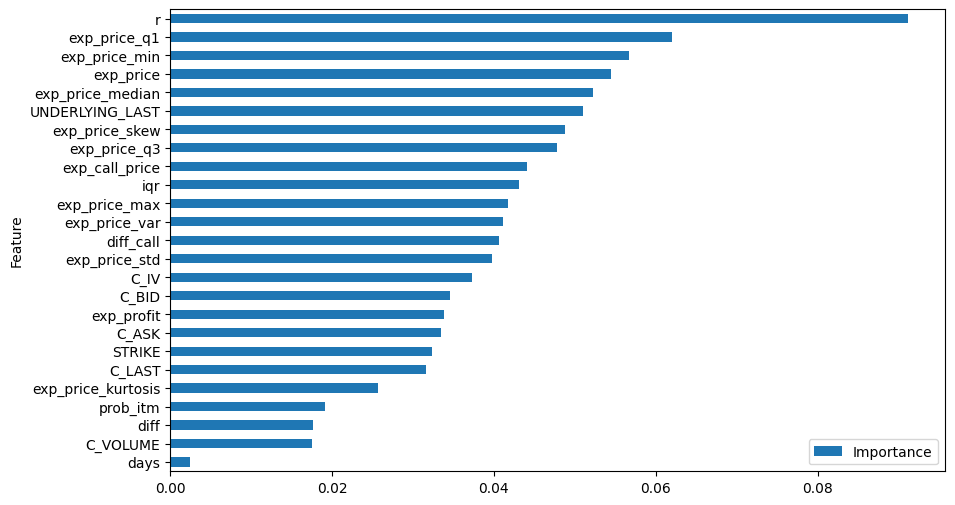

In [53]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [54]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [55]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [56]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,1,388.0,7.72,2023-01-27,405.679993,9.959993,9.959993,42.359978,42.359978
2023-01-09,1,388.0,7.46,2023-01-27,405.679993,10.219993,10.219993,52.579971,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,52.579971,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,235.719956,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,235.719956,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,235.719956,401.389886


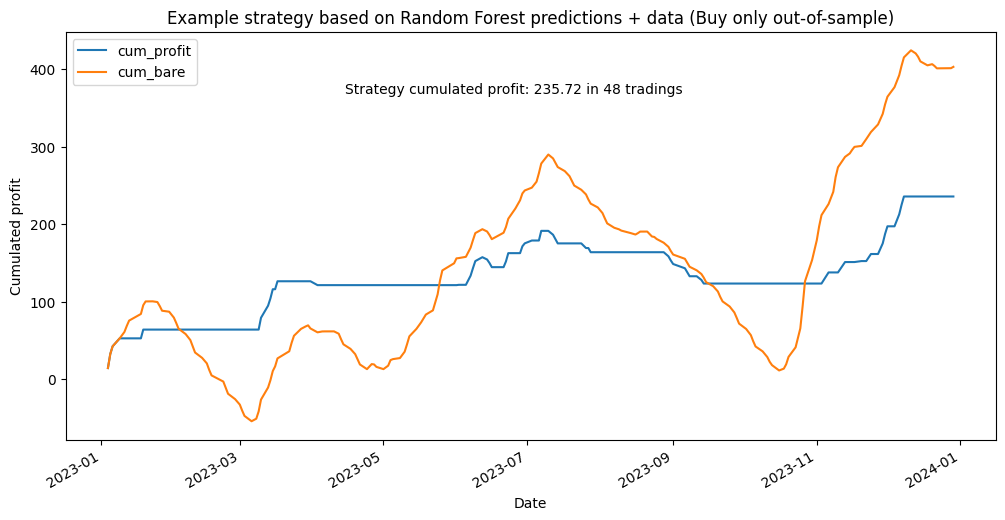

In [57]:
plot_strategy(strategy_df, "Random Forest", "+ data (Buy only out-of-sample)")

## Compare the two predictions

In [58]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [59]:
compare_df[mask_in]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
0,0,1,1,1
2,1,1,0,1
25,1,0,0,0
28,1,0,0,0
31,1,0,0,0
34,1,0,0,0
40,0,0,1,0
42,1,0,0,0
49,0,0,1,1
57,0,0,1,0


In [60]:
compare_df[mask_in].shape

(40, 4)

In [61]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
38,0,0,0,1
41,0,0,0,1
49,0,0,1,1
82,1,0,1,1
84,0,0,0,1
85,0,0,0,1
86,1,0,0,1
87,1,0,1,1
88,1,0,0,1
89,0,0,0,1


In [62]:
compare_df[mask_out].shape

(40, 4)

In [63]:
compare_df.sum(axis=0)

bare_rf_pred_in     94
bare_rf_pred_out     8
mmar_rf_pred_in     90
mmar_rf_pred_out    48
dtype: int64